In [129]:
import pandas as pd
import re
import numpy as np
from scipy import special,stats
import matplotlib.pyplot as plt
%matplotlib inline 
import ast

In [130]:
f = '../../data/sherlock_processed.tsv'

In [6]:
df = pd.read_csv(f, sep = '\t')

In [8]:
def create_df_time(df, time):
    return df[df.PublishDate.str[:7] == time]

In [13]:
timelist = df.PublishDate.drop_duplicates().tolist()
timelist = [str(i)[:7] for i in timelist]
timelist = sorted(list(set(timelist)))[2:]

In [101]:
gamma_all = {}
kudos_all = {}
for month in timelist:
    df_ts = create_df_time(df, month)
    kudos = df_ts.Kudos.astype(float).tolist()
    gamma_all[month] = [ast.literal_eval(gamma) for gamma in df_ts.TopicDistribution.tolist()]
    kudos_all[month] = kudos

In [106]:
def calc_std_dist(gammas): 
    #return average distribution of topics.
    #input:[(topic1, prob1, ...)]
    #output:[ave_prob1, ave_prob2,...]
#     gammas = df.TopicDistribution.tolist()
    gammas_flat = []
    for gamma in gammas:
#         gamma = ast.literal_eval(gamma)
        for elem in gamma:
            gammas_flat.append(elem)
    ave = {}
    for n in range(40):
        t = []
        for i in gammas_flat:
            if i[0] == n:
                t.append(i[1])
        ave[n] = sum(t)/float(len(gammas))
    return ave.values()

In [102]:
def calc_kl(p, q):
    return sum([p[i]*(np.log2(p[i]/q[i])) for i in range(len(p))])

In [103]:
def return_gammas(gamma_list):
    return [i[1] for i in gamma_list]

In [111]:
def calc_corr(month):
#     cor_all = []
    std_dist = calc_std_dist(gamma_all.get(month))
    kls = []
    for i in gamma_all.get(month):
        gammas = return_gammas(i)
        kls.append(calc_kl(gammas, std_dist))
        
    #fill in works with no kudos with 0.
    for k in kudos_all[month]:
        if np.isnan(k):
            kudos_all[month][kudos_all[month].index(k)] = 0

    cor = stats.pearsonr(kls, kudos_all[month])[0]
    return cor

In [122]:
def calc_ave_kl_ts(this_month, des_month):
    std_dist = calc_std_dist(gamma_all.get(des_month))
    kls = []
    for i in gamma_all.get(this_month):
        gammas = return_gammas(i)
        kls.append(calc_kl(gammas, std_dist))
    return np.average(kls)

In [123]:
def calc_ave_kl_ts_rev(this_month, des_month):
    std_dist = calc_std_dist(gamma_all.get(des_month))
    kls = []
    for i in gamma_all.get(this_month):
        gammas = return_gammas(i)
        kls.append(calc_kl(std_dist, gammas))
    return np.average(kls)

In [124]:
def calc_ave_kl_ts_inter(interval):
    kl_inter = []
    for i in range(len(timelist) - interval):
        kl_inter.append(calc_ave_kl_ts(timelist[i+interval], timelist[i]))
    kl_inter = np.average(kl_inter)
    return kl_inter

In [125]:
def calc_ave_kl_ts_neg_inter(interval):
    kl_inter = []
    timelist_r = timelist[::-1]
    for i in range(len(timelist_r) - interval):
        kl_inter.append(calc_ave_kl_ts(timelist[i+interval], timelist[i]))
    kl_inter = np.average(kl_inter)
    return kl_inter

In [126]:
def calc_ave_kl_ts_inter_rev(interval):
    kl_inter = []
    for i in range(len(timelist) - interval):
        kl_inter.append(calc_ave_kl_ts_rev(timelist[i+interval], timelist[i]))
    kl_inter = np.average(kl_inter)
    return kl_inter

In [127]:
def calc_ave_kl_ts_neg_inter_rev(interval):
    kl_inter = []
    timelist_r = timelist[::-1]
    for i in range(len(timelist_r) - interval):
        kl_inter.append(calc_ave_kl_ts_rev(timelist[i+interval], timelist[i]))
    kl_inter = np.average(kl_inter)
    return kl_inter

In [ ]:
kl_inters = {}
for i in range(len(timelist)):
    kl_inters[i] = calc_ave_kl_ts_inter(i)
for i in range(len(timelist)):
    kl_inters[-i] = calc_ave_kl_ts_neg_inter(i)

###Plotting

###Correlation between KL and kudos

In [112]:
cor_all = []
for month in timelist:
    cor_all.append(calc_corr(month))

In [113]:
np.average(cor_all)

-0.081697333038009468

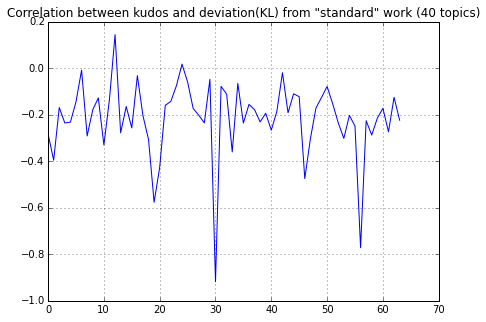

In [26]:
fig, ax = plt.subplots(figsize = (7, 5))
ax.plot(cor_all)
plt.grid()
ax.set_title('Correlation between kudos and deviation(KL) from "standard" work (40 topics)')

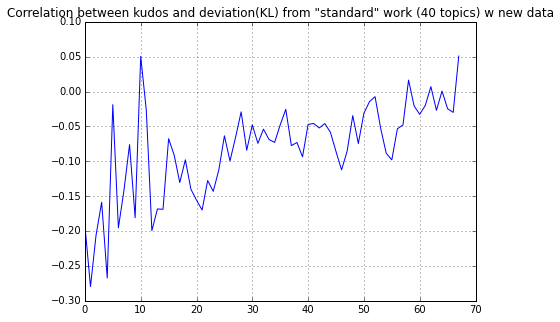

In [116]:
fig, ax = plt.subplots(figsize = (7, 5))
ax.plot(cor_all)
plt.grid()
ax.set_title('Correlation between kudos and deviation(KL) from "standard" work (40 topics) w new data')

In [115]:
kl_ave = []
for month in timelist:
    std_dist = calc_std_dist(gamma_all.get(month))
    kls = []
    for i in gamma_all.get(month):
        kls.append(calc_kl([j[1] for j in i], std_dist))
    kl_ave.append(np.average(kls))

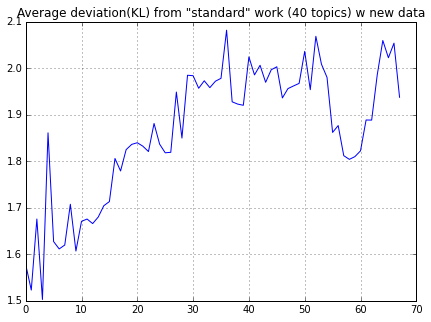

In [117]:
fig, ax = plt.subplots(figsize = (7, 5))
ax.plot(kl_ave)
ax.set_title('Average deviation(KL) from "standard" work (40 topics) w new data')
plt.grid()

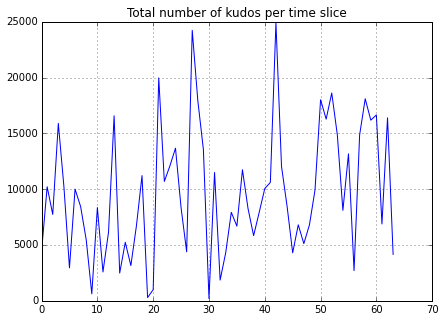

In [219]:
fig, ax = plt.subplots(figsize = (7, 5))
ax.plot([sum(k) for k in kudos_all.values()])
ax.set_title('Total number of kudos per time slice')
plt.grid()

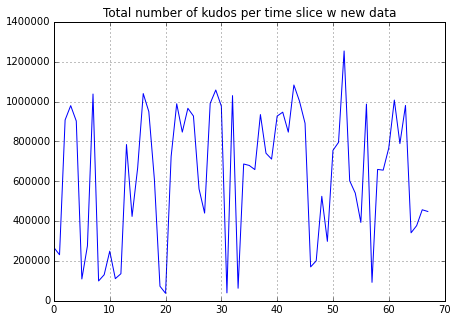

In [118]:
fig, ax = plt.subplots(figsize = (7, 5))
ax.plot([sum(k) for k in kudos_all.values()])
ax.set_title('Total number of kudos per time slice w new data')
plt.grid()

In [119]:
work_count = []
for month in timelist:
    df_ts = create_df_time(df, month)
    work_count.append(len(df_ts))

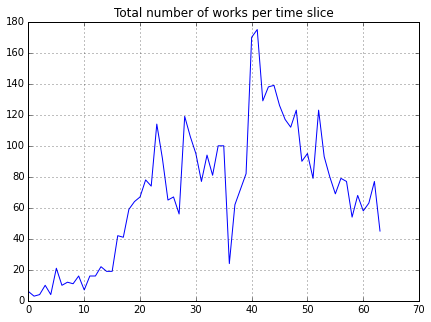

In [221]:
fig, ax = plt.subplots(figsize = (7, 5))
ax.plot(work_count)
ax.set_title('Total number of works per time slice')
plt.grid()

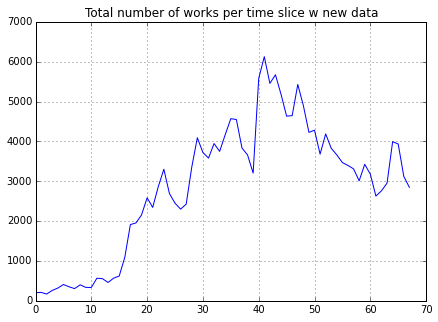

In [120]:
fig, ax = plt.subplots(figsize = (7, 5))
ax.plot(work_count)
ax.set_title('Total number of works per time slice w new data')
plt.grid()

###KL over different time length

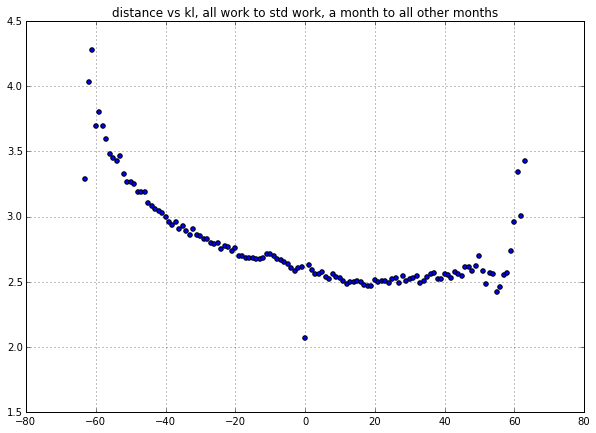

In [25]:
fig, ax = plt.subplots(figsize = (10, 7))
ax.scatter(kl_inters.keys(), kl_inters.values())
ax.set_title('distance vs kl, all work to std work, a month to all other months')
plt.grid()

###Considering different orders because KL is asymmetric

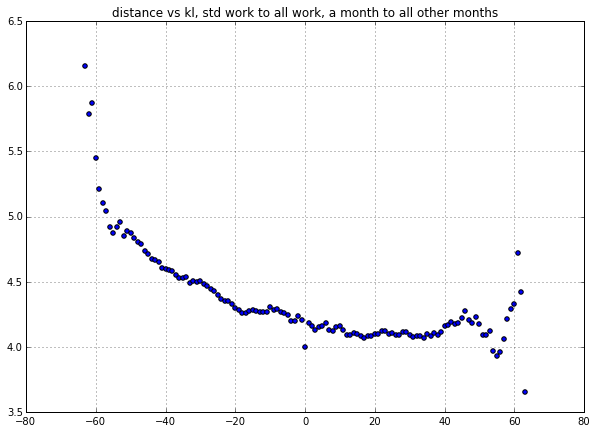

In [51]:
fig, ax = plt.subplots(figsize = (10, 7))
ax.scatter(kl_inters.keys(), kl_inters.values())
ax.set_title('distance vs kl, std work to all work, a month to all other months')
plt.grid()

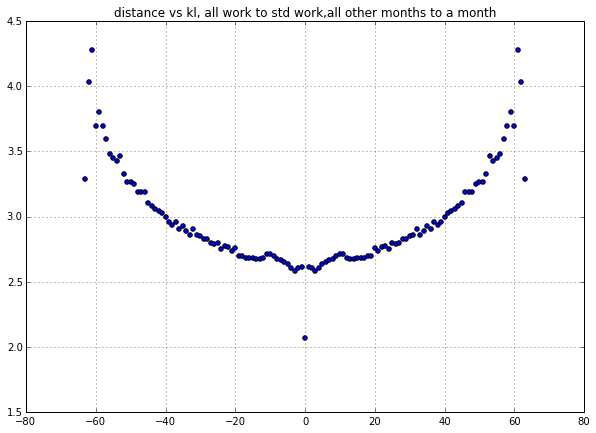

In [57]:
fig, ax = plt.subplots(figsize = (10, 7))
ax.scatter(kl_inters.keys(), kl_inters.values())
ax.set_title('distance vs kl, all work to std work,all other months to a month')
plt.grid()

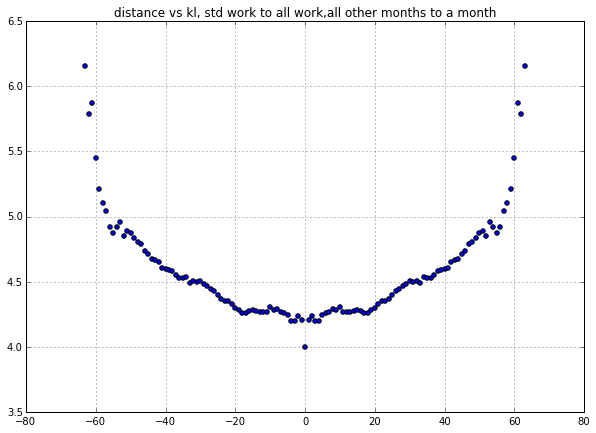

In [59]:
fig, ax = plt.subplots(figsize = (10, 7))
ax.scatter(kl_inters.keys(), kl_inters.values())
ax.set_title('distance vs kl, std work to all work,all other months to a month')
plt.grid()